In [1]:
suppressMessages(library(purrr))
suppressMessages(library(Seurat))
suppressMessages(library(sva))
suppressMessages(library(ggplot2))
suppressMessages(library(dplyr))
suppressMessages(library(harmony))
suppressMessages(library(stringr))
suppressMessages(library(MAESTRO))

# load data

In [2]:
source('~/Normal_process/src/functions.R')

In [3]:
files <- list.files("/fs/home/shixiaoying/Project/SELINA/Liver/Adult/", pattern = "[0-9]+_res.rds$", full.names = T, recursive = T)

In [4]:
data_list <- map(files, readRDS)

# curation

In [5]:
for (i in 1:length(data_list)){
    print(i)
    print(unique(data_list[[i]]$manual.assign))
    print(unique(data_list[[i]]$curated.assign))
}

[1] 1
 [1] "Central venous LSEC"     "Cholangiocyte"          
 [3] "Kupffer cell"            "T"                      
 [5] "Inflammatory macrophage" "NK"                     
 [7] "Hepatocyte"              "Portal endothelial cell"
 [9] "Periportal LSEC"         "B"                      
[11] "Plasma"                  "Erthyroid"              
 [1] "Central Venous LSEC" "Cholangiocyte"       "Kupffer"            
 [4] "T"                   "Macrophage"          "NK"                 
 [7] "Hepatocyte"          "Portal Endothelial"  "Periportal LSEC"    
[10] "B"                   "Plasma"              "Erythrocyte"        
[1] 2
[1] "T cell"           "Endothelial cell" "B cell"           "Neutrophil"      
[5] "Macrophage"       "Hepatocyte"       "Kupffer cell"     "Epithelial cell" 
[9] "Mast cell"       
[1] "T"           "Endothelial" "B"           "Neutrophil"  "Macrophage" 
[6] "Hepatocyte"  "Kupffer"     "Epithelial"  "Mast"       
[1] 3
[1] "Kupffer cell"     "Dendritic cell"

In [6]:
celltype = c()
for (i in 1:length(data_list)){
    celltype = c(celltype,data_list[[i]]$manual.assign)
}
celltype[celltype == 'Central venous LSEC']='Central Venous LSEC'
celltype[celltype == 'Inflammatory macrophage']='Macrophage'
celltype[celltype == 'Portal endothelial cell']='Portal Endothelial'
celltype[celltype == 'Dendritic cell']='DC'
celltype[celltype == 'Mesenchyme']='Mesenchymal'
celltype = gsub(' cells','',celltype)
celltype = gsub(' cell','',celltype)
print(as.data.frame(unique(celltype)))

      unique(celltype)
1  Central Venous LSEC
2        Cholangiocyte
3              Kupffer
4                    T
5           Macrophage
6                   NK
7           Hepatocyte
8   Portal Endothelial
9      Periportal LSEC
10                   B
11              Plasma
12           Erthyroid
13         Endothelial
14          Neutrophil
15          Epithelial
16                Mast
17                  DC
18              Muscle
19            Monocyte
20                 pDC
21                 cDC
22         Mesenchymal


In [7]:
for (i in 1:length(data_list)){
    data_list[[i]]$curated.assign = data_list[[i]]$manual.assign
    data_list[[i]]$curated.assign[data_list[[i]]$curated.assign == 'Central venous LSEC']='Central Venous LSEC'
    data_list[[i]]$curated.assign[data_list[[i]]$curated.assign == 'Inflammatory macrophage']='Macrophage'
    data_list[[i]]$curated.assign[data_list[[i]]$curated.assign == 'Portal endothelial cell']='Portal Endothelial'
    data_list[[i]]$curated.assign[data_list[[i]]$curated.assign == 'Dendritic cell']='DC'
    data_list[[i]]$curated.assign[data_list[[i]]$curated.assign == 'Mesenchyme']='Mesenchymal'
    data_list[[i]]$curated.assign = gsub(' cells','',data_list[[i]]$curated.assign)
    data_list[[i]]$curated.assign = gsub(' cell','',data_list[[i]]$curated.assign)
}

In [8]:
for (i in 1:length(data_list)){
    ct_number = table(data_list[[i]]$curated.assign)
    ct = names(ct_number)
    for (j in 1:length(ct)){
        if (ct_number[j]<=10){
            if (!str_detect(ct[j],'Unknown')){
                data_list[[i]]$curated.assign[data_list[[i]]$curated.assign == ct[j]] = paste0(ct[j],'_Unknown')
            }
        }
    }
    data_list[[i]]$temp.assign = data_list[[i]]$curated.assign
}

In [9]:
celltype = c()
for (i in 1:length(data_list)){
    celltype = c(celltype,data_list[[i]]$curated.assign)
}
print(as.data.frame(unique(celltype)))

      unique(celltype)
1  Central Venous LSEC
2        Cholangiocyte
3              Kupffer
4                    T
5           Macrophage
6                   NK
7           Hepatocyte
8   Portal Endothelial
9      Periportal LSEC
10                   B
11              Plasma
12           Erthyroid
13         Endothelial
14          Neutrophil
15          Epithelial
16                Mast
17                  DC
18  Neutrophil_Unknown
19              Muscle
20            Monocyte
21                 pDC
22                 cDC
23         Mesenchymal


In [10]:
level = read.table('./level.txt',header = T,stringsAsFactors = F,sep = '\t')

In [11]:
level

unified             level1          level2     
1  Kupffer             Immune          Kupffer    
2  T                   Immune          T          
3  Macrophage          Immune          Macrophage 
4  NK                  Immune          NK         
5  B                   Immune          B          
6  Plasma              Immune          Plasma     
7  Erthyroid           Immune          Erthyroid  
8  Neutrophil          Immune          Neutrophil 
9  Mast                Immune          Mast       
10 Monocyte            Immune          Monocyte   
11 DC                  Immune          DC         
12 pDC                 Immune          DC         
13 cDC                 Immune          DC         
14 Endothelial         Stromal         Endothelial
15 Portal Endothelial  Stromal         Endothelial
16 Periportal LSEC     Stromal         Endothelial
17 Central Venous LSEC Stromal         Endothelial
18 Epithelial          Tissue-specific Epithelial 
19 Cholangiocyte       Tissue-specific Epithelial 
20 Hepatocyte          Tissue-specific Epithelial 
21 Mesenchymal         Tissue-specific Mesenchymal

# level1

In [12]:
#level1
for (i in 1:length(data_list)){
    data_list[[i]]$level1 = data_list[[i]]$curated.assign
    for (j in 1:nrow(level)){
        data_list[[i]]$level1[data_list[[i]]$curated.assign %in% level$unified[level$level1==level[j,'level1']]] = level[j,'level1']
    }
}

In [13]:
celltype = c()
for (i in 1:length(data_list)){
    celltype = c(celltype,data_list[[i]]$level1)
}
print(as.data.frame(unique(celltype)))

    unique(celltype)
1            Stromal
2    Tissue-specific
3             Immune
4 Neutrophil_Unknown
5             Muscle


# level2

In [14]:
#level2
for (i in 1:length(data_list)){
    data_list[[i]]$level2 = data_list[[i]]$curated.assign
    for (j in 1:nrow(level)){
        data_list[[i]]$level2[data_list[[i]]$curated.assign %in% level$unified[level$level2==level[j,'level2']]] = level[j,'level2']
    }  
}

In [15]:
celltype = c()
for (i in 1:length(data_list)){
    celltype = c(celltype,data_list[[i]]$level2)
}
print(as.data.frame(unique(celltype)))

     unique(celltype)
1         Endothelial
2          Epithelial
3             Kupffer
4                   T
5          Macrophage
6                  NK
7                   B
8              Plasma
9           Erthyroid
10         Neutrophil
11               Mast
12                 DC
13 Neutrophil_Unknown
14             Muscle
15           Monocyte
16        Mesenchymal


In [16]:
#T cell 
signatures <- read.table('/fs/home/renpengfei/Normal_process/signature/T_level2.txt')
lineage = lineage_extract(lineage_cells = c('T','CD4T','CD8T'),level = 'level2')
lineage = suppressWarnings(harmony(lineage,'project'))

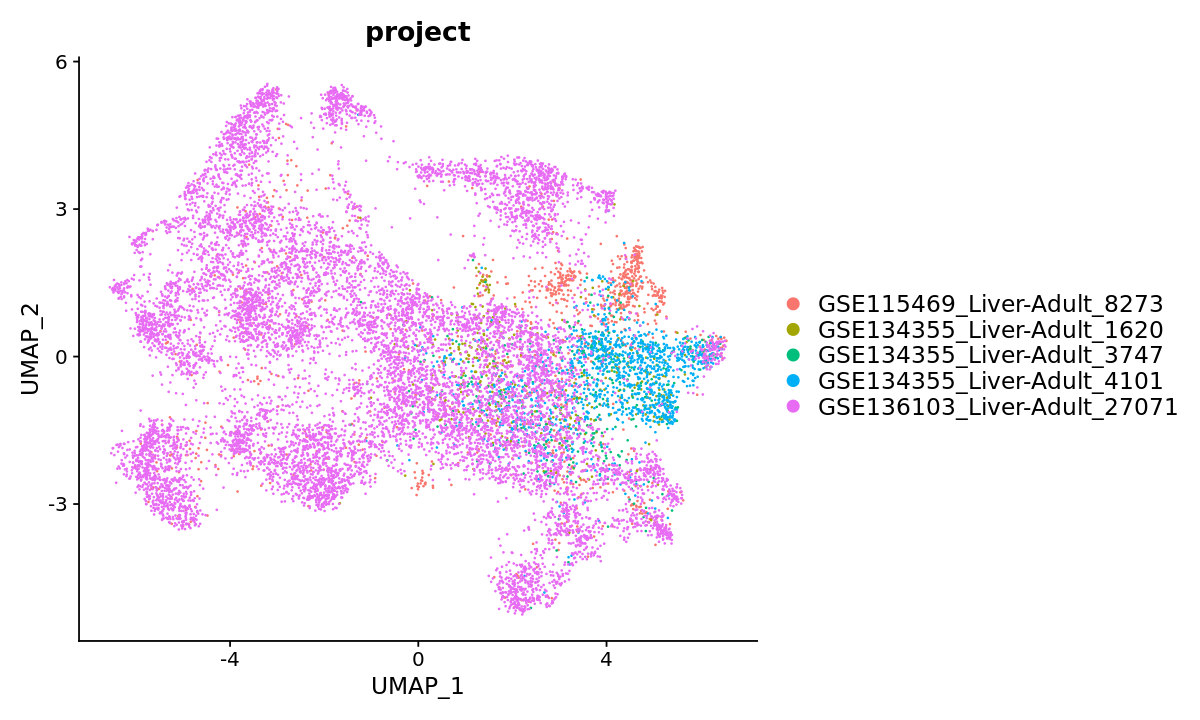

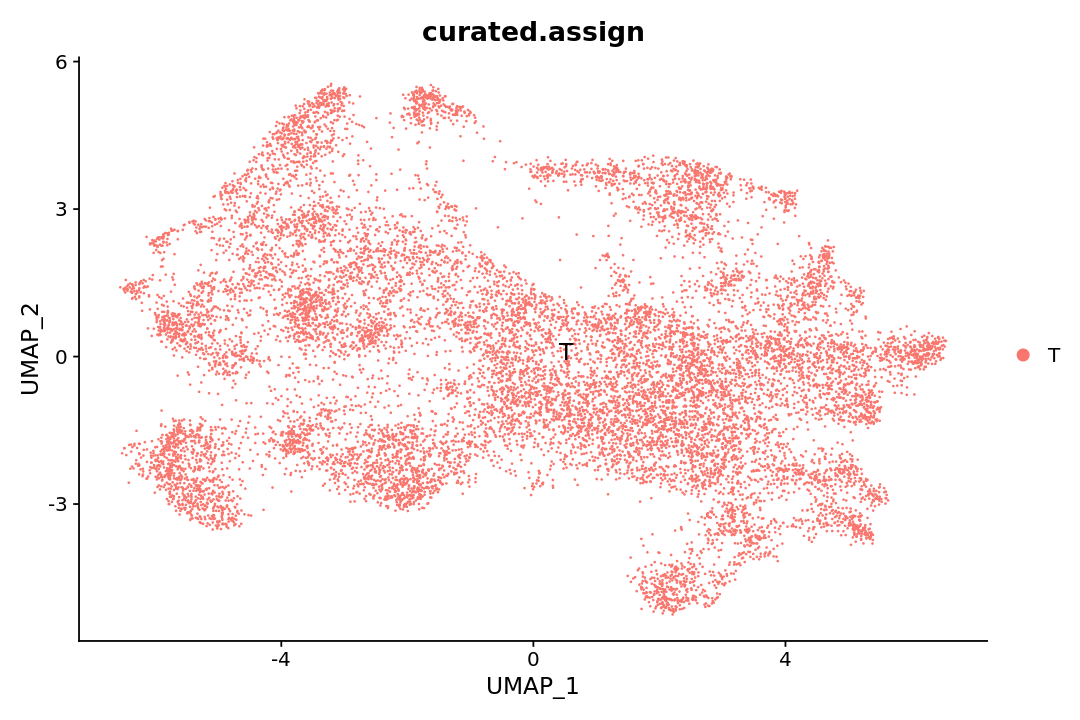

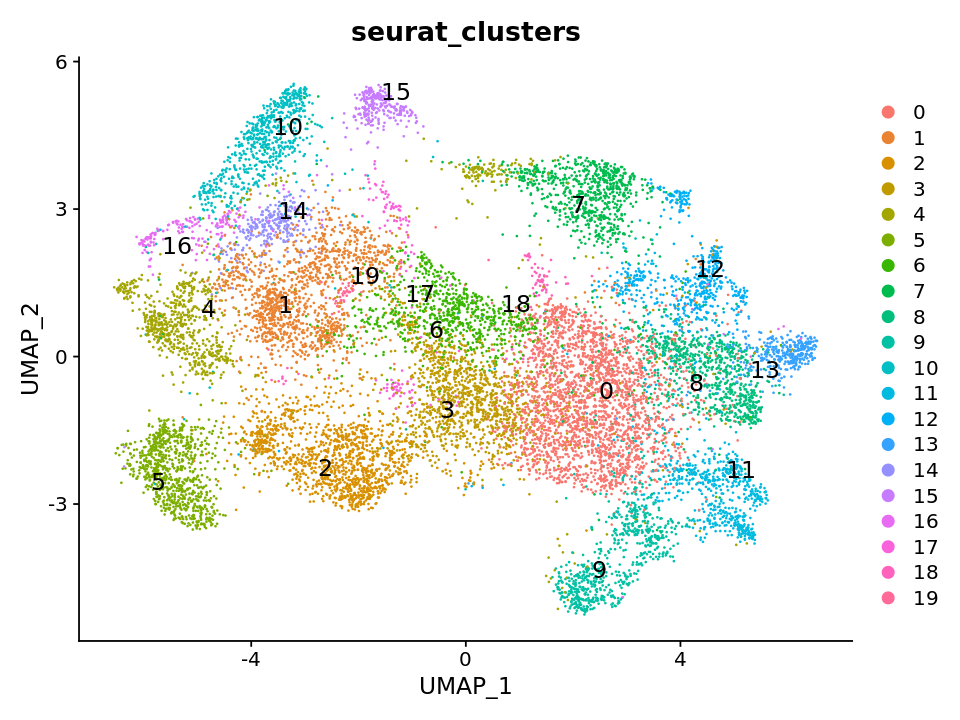

In [17]:
options(repr.plot.height=6,repr.plot.width=10)
print(DimPlot(lineage,group.by = 'project') + theme(legend.text = element_text(size = 14))) 
options(repr.plot.height=6,repr.plot.width=9)
print(DimPlot(lineage,group.by = 'curated.assign',label = T, repel = T, label.size = 5))
options(repr.plot.height=6,repr.plot.width=8)
print(DimPlot(lineage,group.by = 'seurat_clusters',label = T, repel = T, label.size = 5))

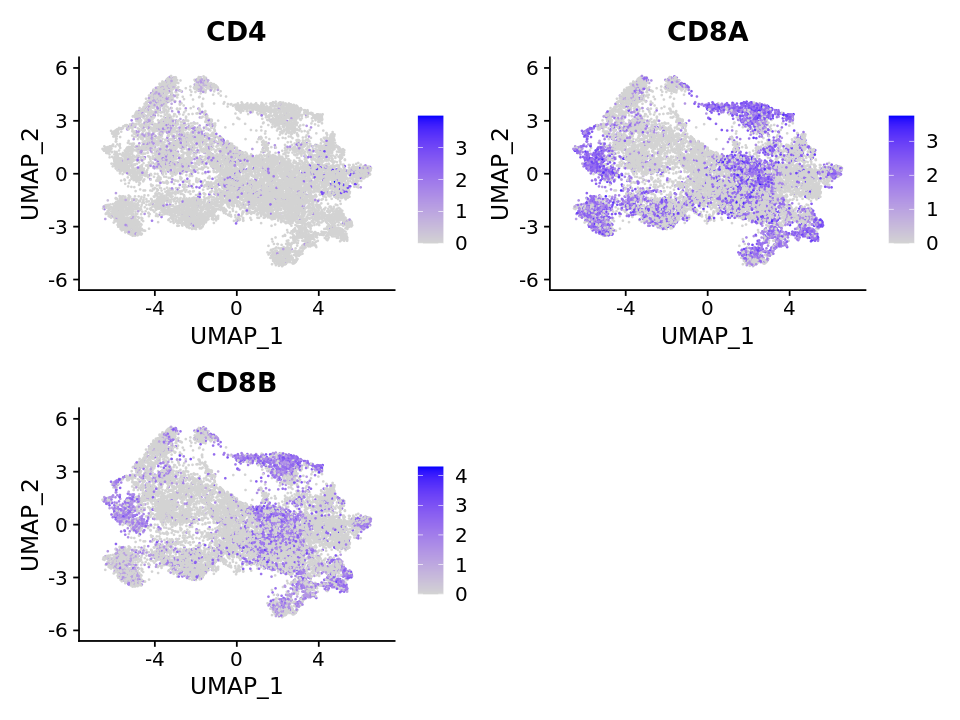

In [18]:
FeaturePlot(lineage,features = c('CD4','CD8A','CD8B'))

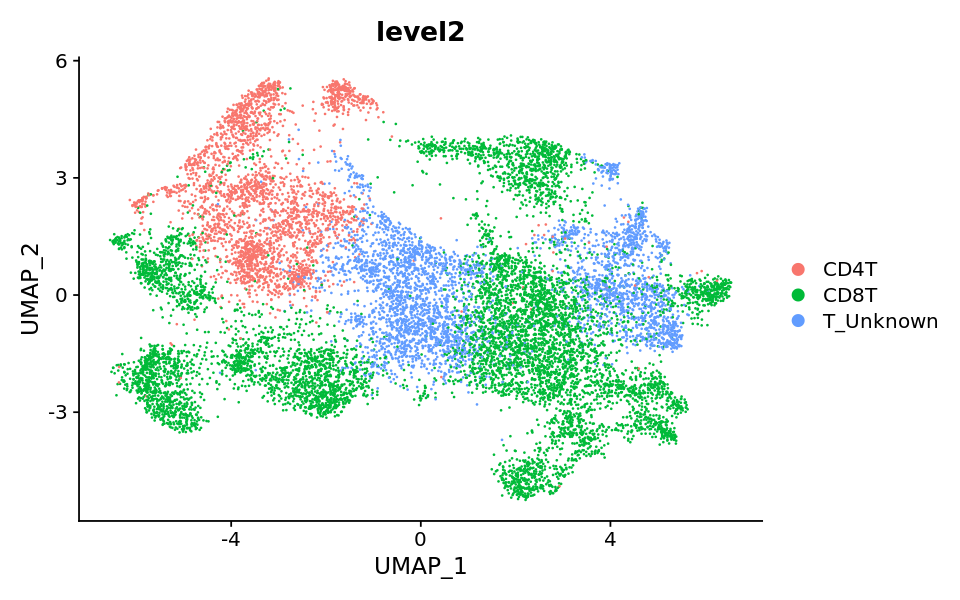

In [19]:
CD4T = colnames(lineage)[which(lineage$seurat_clusters %in%c(1,19,14,16,10,15))]
names(CD4T) = unlist(lapply(CD4T,function(x){
    x = unlist(str_split(x,';'))[1]
}))
lineage$level2[which(colnames(lineage) %in% CD4T)] = 'CD4T'

CD8T = colnames(lineage)[which(lineage$seurat_clusters %in%c(7,18,0,11,9,4,5,2,13))]
names(CD8T) = unlist(lapply(CD8T,function(x){
    x = unlist(str_split(x,';'))[1]
}))
lineage$level2[which(colnames(lineage) %in% CD8T)] = 'CD8T'

T = colnames(lineage)[which(lineage$seurat_clusters %in%c(17,6,3,12,8))]
names(T) = unlist(lapply(T,function(x){
    x = unlist(str_split(x,';'))[1]
}))
lineage$level2[which(colnames(lineage) %in% T)] = 'T_Unknown'

options(repr.plot.height=5,repr.plot.width=8)
DimPlot(lineage,group.by = 'level2')

In [20]:
for (i in 1:length(data_list)){
    data_parent = colnames(data_list[[i]])[which(data_list[[i]]$level2 == 'T')]
    
    data_children = CD4T[names(CD4T) == data_list[[i]]@project.name]
    data_children = unlist(lapply(data_children,function(x){
        x = unlist(str_split(x,';'))[2]
    }))
    data_children = data_parent[data_parent %in% data_children]
    data_list[[i]]@meta.data[data_children,'level2'] = 'CD4T'
    data_list[[i]]@meta.data[data_children,'temp.assign'] = 'CD4T'
    
    data_children = CD8T[names(CD8T) == data_list[[i]]@project.name]
    data_children = unlist(lapply(data_children,function(x){
        x = unlist(str_split(x,';'))[2]
    }))
    data_children = data_parent[data_parent %in% data_children]
    data_list[[i]]@meta.data[data_children,'level2'] = 'CD8T'
    data_list[[i]]@meta.data[data_children,'temp.assign'] = 'CD8T'
    
    data_children = T[names(T) == data_list[[i]]@project.name]
    data_children = unlist(lapply(data_children,function(x){
        x = unlist(str_split(x,';'))[2]
    }))
    data_children = data_parent[data_parent %in% data_children]
    data_list[[i]]@meta.data[data_children,'level2'] = 'T_Unknown'
    data_list[[i]]@meta.data[data_children,'temp.assign'] = 'T_Unknown'
    
}

# level3

In [21]:
#level3
for (i in 1:length(data_list)){
    data_list[[i]]$level3 = data_list[[i]]$temp.assign
}

In [22]:
celltype = c()
for (i in 1:length(data_list)){
    celltype = c(celltype,data_list[[i]]$level3)
}
print(as.data.frame(unique(celltype)))

      unique(celltype)
1  Central Venous LSEC
2        Cholangiocyte
3              Kupffer
4                 CD8T
5           Macrophage
6                   NK
7            T_Unknown
8           Hepatocyte
9   Portal Endothelial
10     Periportal LSEC
11                   B
12              Plasma
13                CD4T
14           Erthyroid
15         Endothelial
16          Neutrophil
17          Epithelial
18                Mast
19                  DC
20  Neutrophil_Unknown
21              Muscle
22            Monocyte
23                 pDC
24                 cDC
25         Mesenchymal


In [23]:
lineage = lineage_extract(lineage_cells = c('Endothelial'),level = 'level2')
lineage = harmony(lineage,'project')

Warning message:
"Invalid name supplied, making object name syntactically valid. New object name is Seurat..ProjectDim.RNA.harmony; see ?make.names for more details on syntax validity"


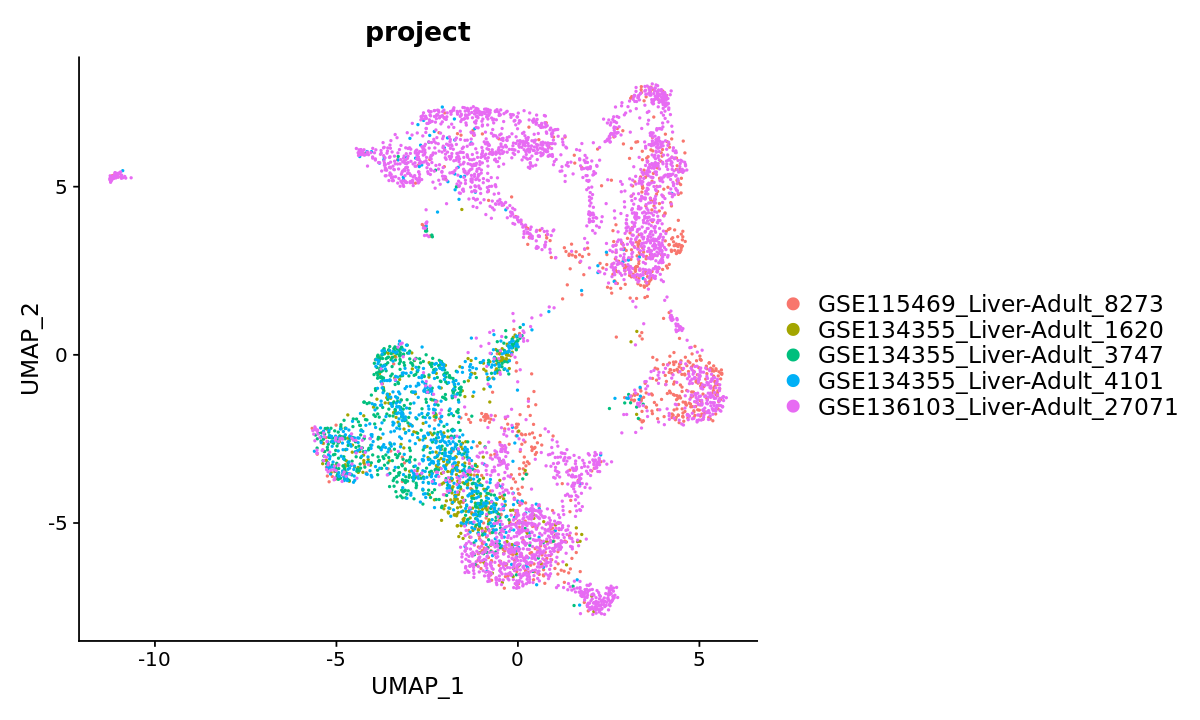

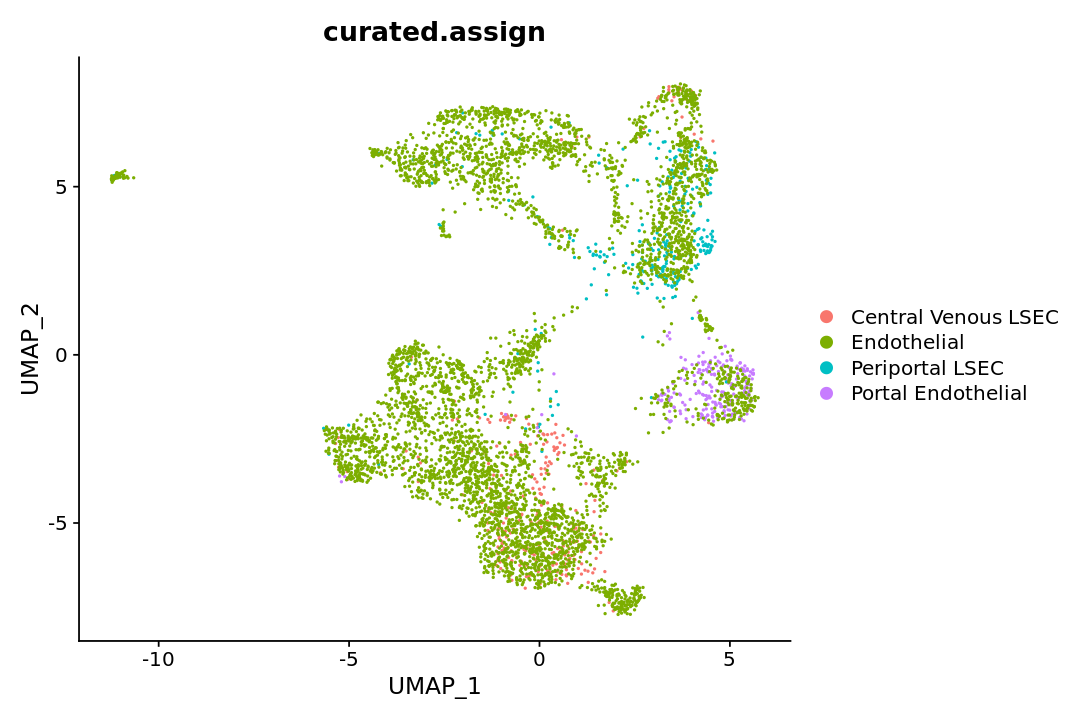

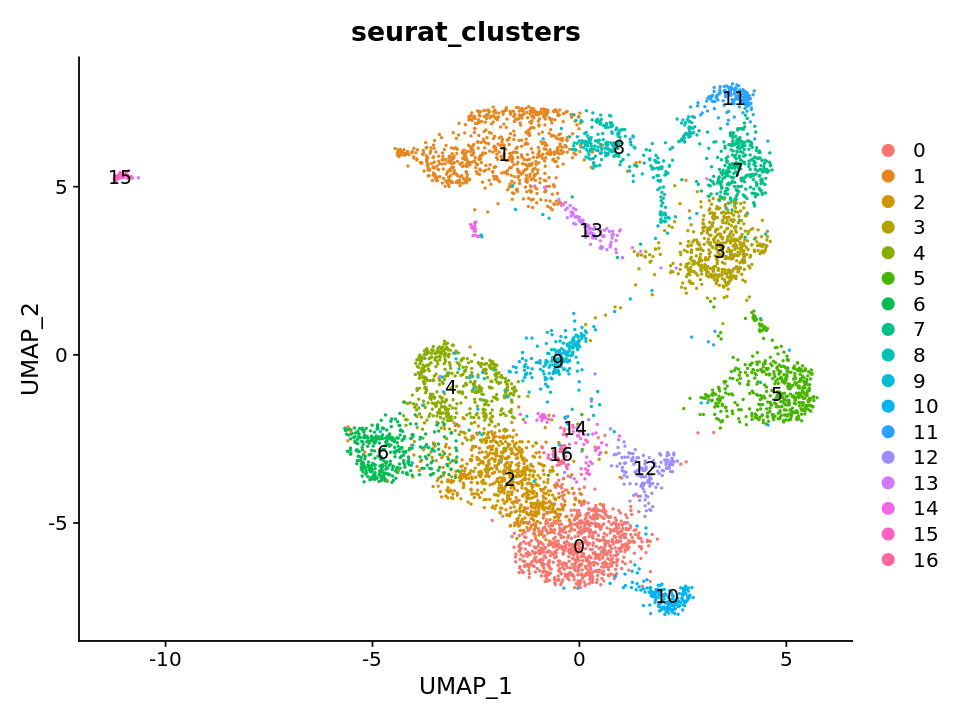

In [24]:
options(repr.plot.height=6,repr.plot.width=10)
print(DimPlot(lineage,group.by = 'project') + theme(legend.text = element_text(size = 14))) 
options(repr.plot.height=6,repr.plot.width=9)
print(DimPlot(lineage,group.by = 'curated.assign'))
options(repr.plot.height=6,repr.plot.width=8)
print(DimPlot(lineage,group.by = 'seurat_clusters',label = TRUE))

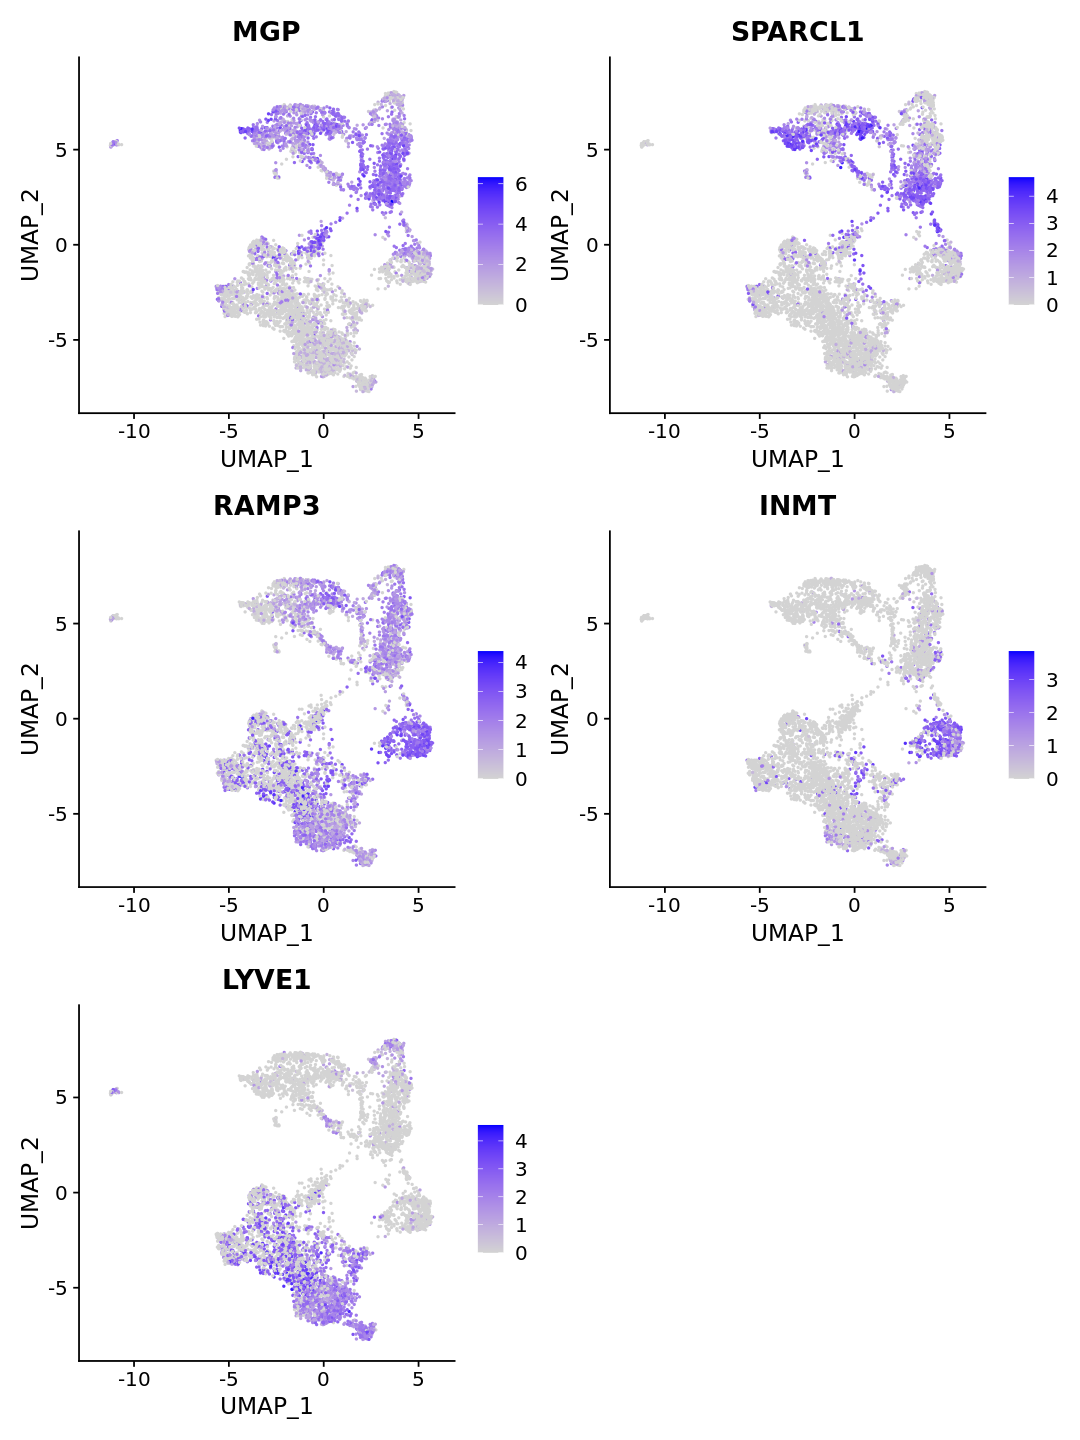

In [25]:
options(repr.plot.height=12,repr.plot.width=9)
FeaturePlot(lineage,features = c('MGP','SPARCL1','RAMP3','INMT','LYVE1'))

In [26]:
children_clusters = list()
children_clusters[['Central Venous LSEC']] = c(0,2,4,6,10,12,14,16)
children_clusters[['Periportal LSEC']] = c(1,8,13,7,3)
children_clusters[['Portal Endothelial']] = c(5)
children_clusters[['Endothelial']] = c(9,11,15)

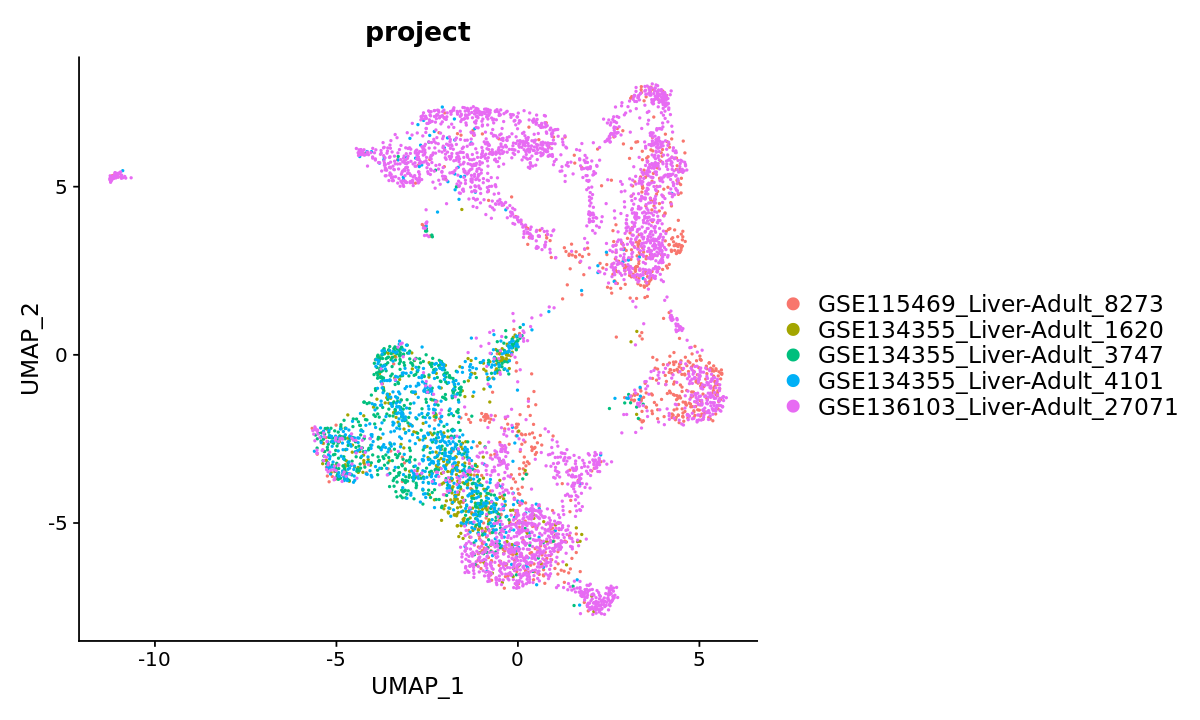

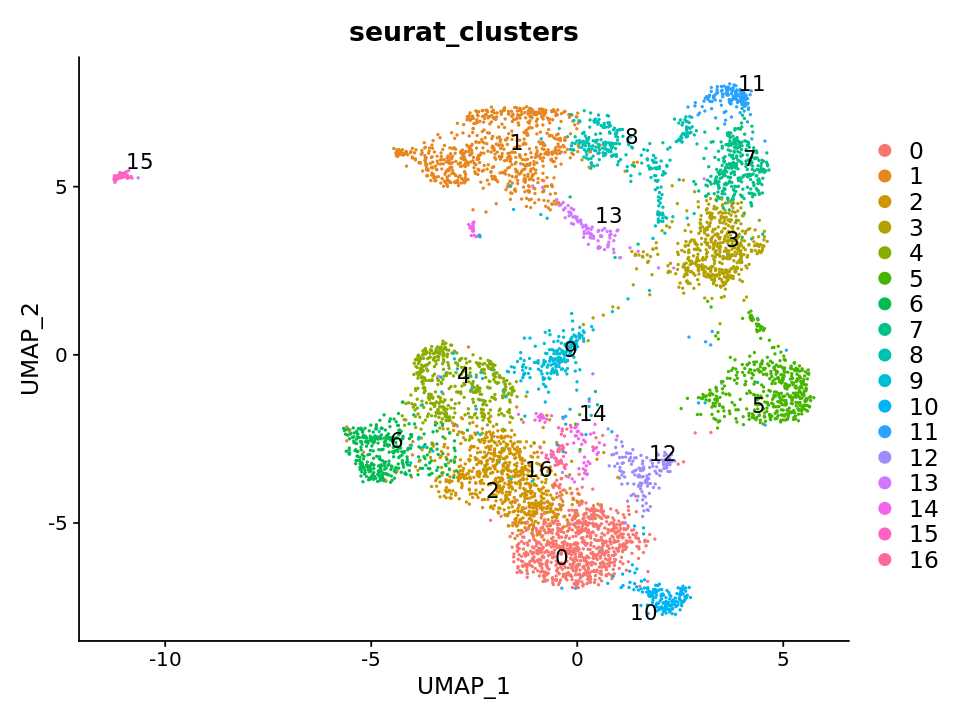

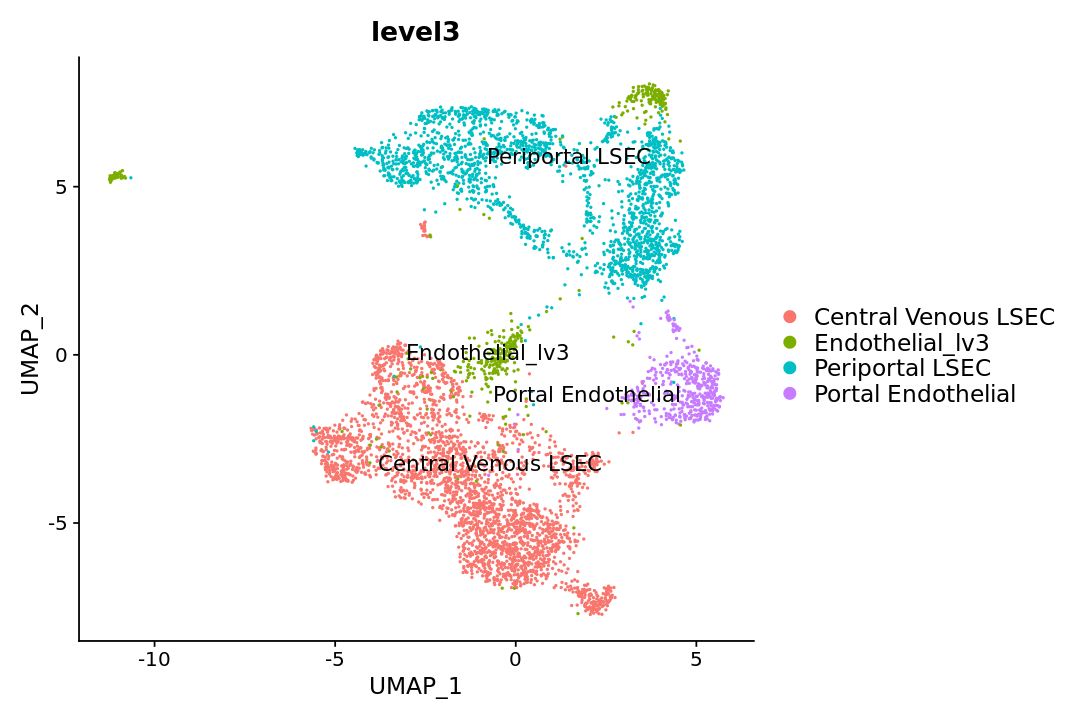

In [27]:
data_list = l3_assign(seurat_obj = lineage,children_clusters = children_clusters,Parent = 'Endothelial')

In [28]:
#Epithelial
lineage = lineage_extract(lineage_cells = c('Epithelial'),level = 'level2')
lineage = harmony(lineage,'project')

Warning message:
"Invalid name supplied, making object name syntactically valid. New object name is Seurat..ProjectDim.RNA.harmony; see ?make.names for more details on syntax validity"


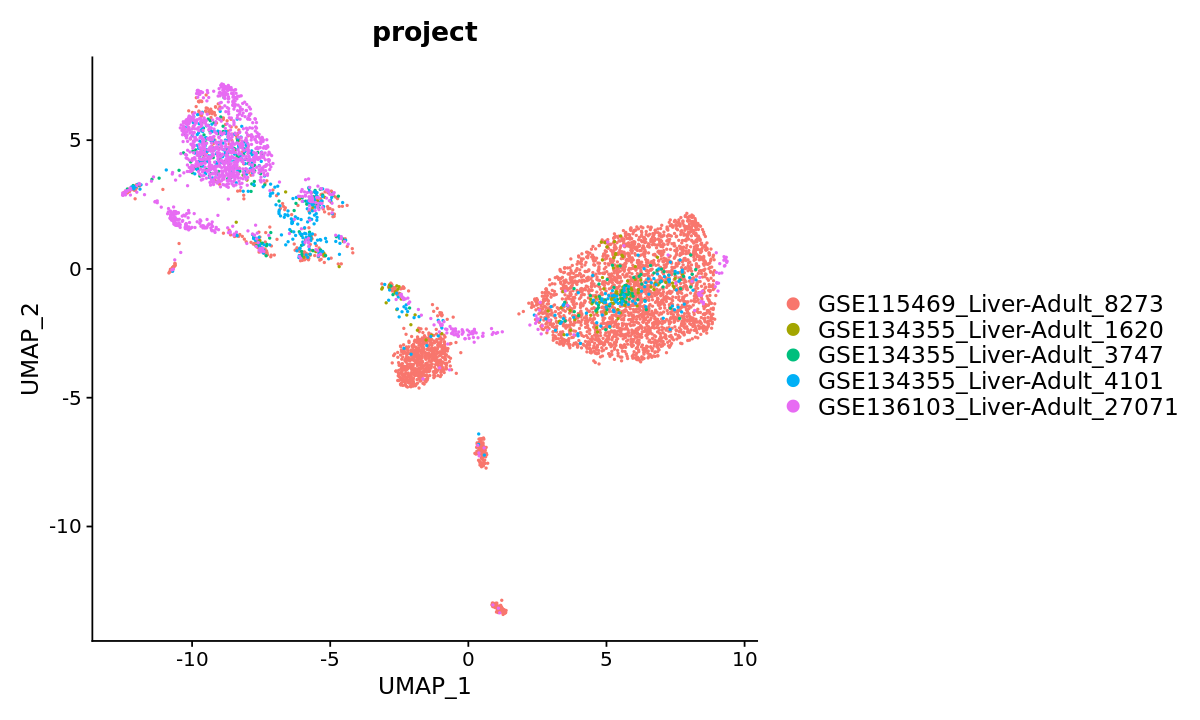

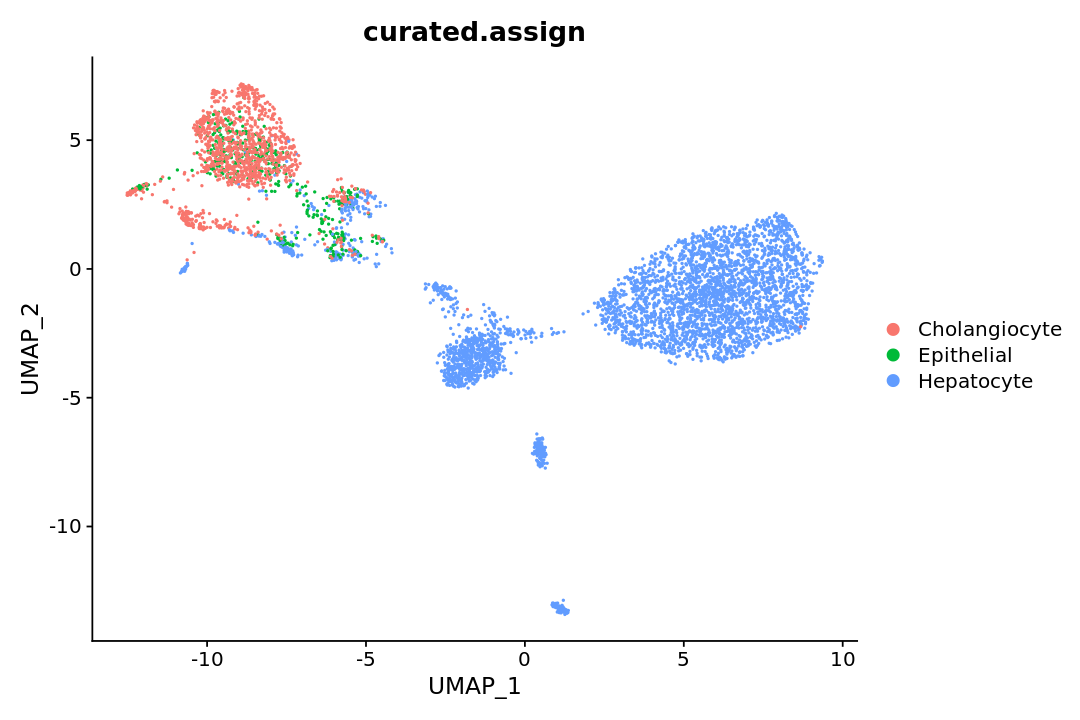

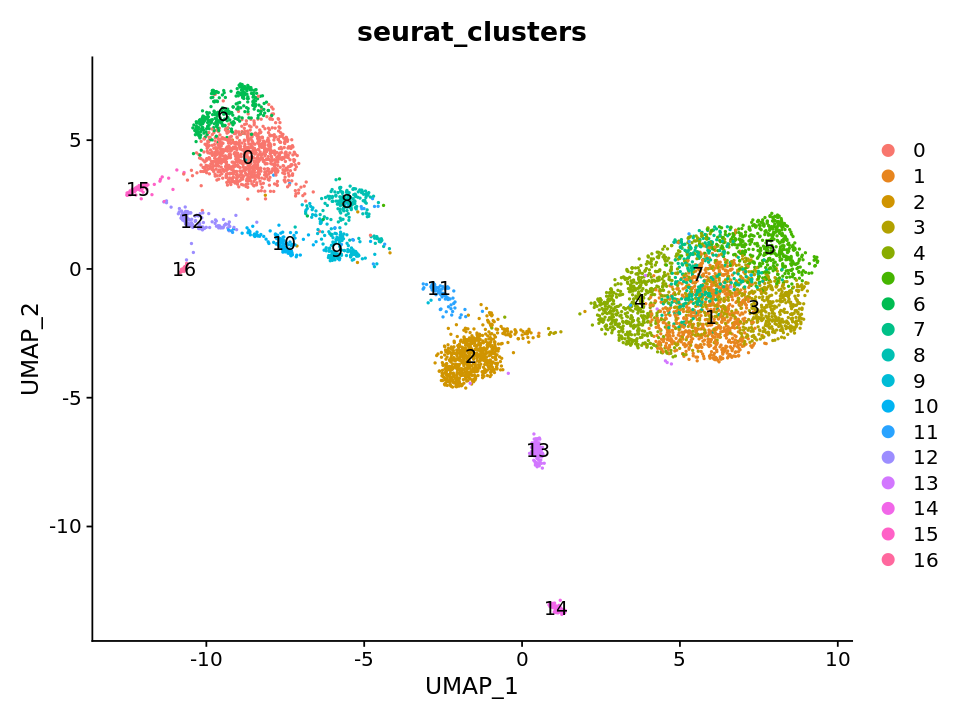

In [29]:
options(repr.plot.height=6,repr.plot.width=10)
print(DimPlot(lineage,group.by = 'project') + theme(legend.text = element_text(size = 14))) 
options(repr.plot.height=6,repr.plot.width=9)
print(DimPlot(lineage,group.by = 'curated.assign'))
options(repr.plot.height=6,repr.plot.width=8)
print(DimPlot(lineage,group.by = 'seurat_clusters',label = TRUE))

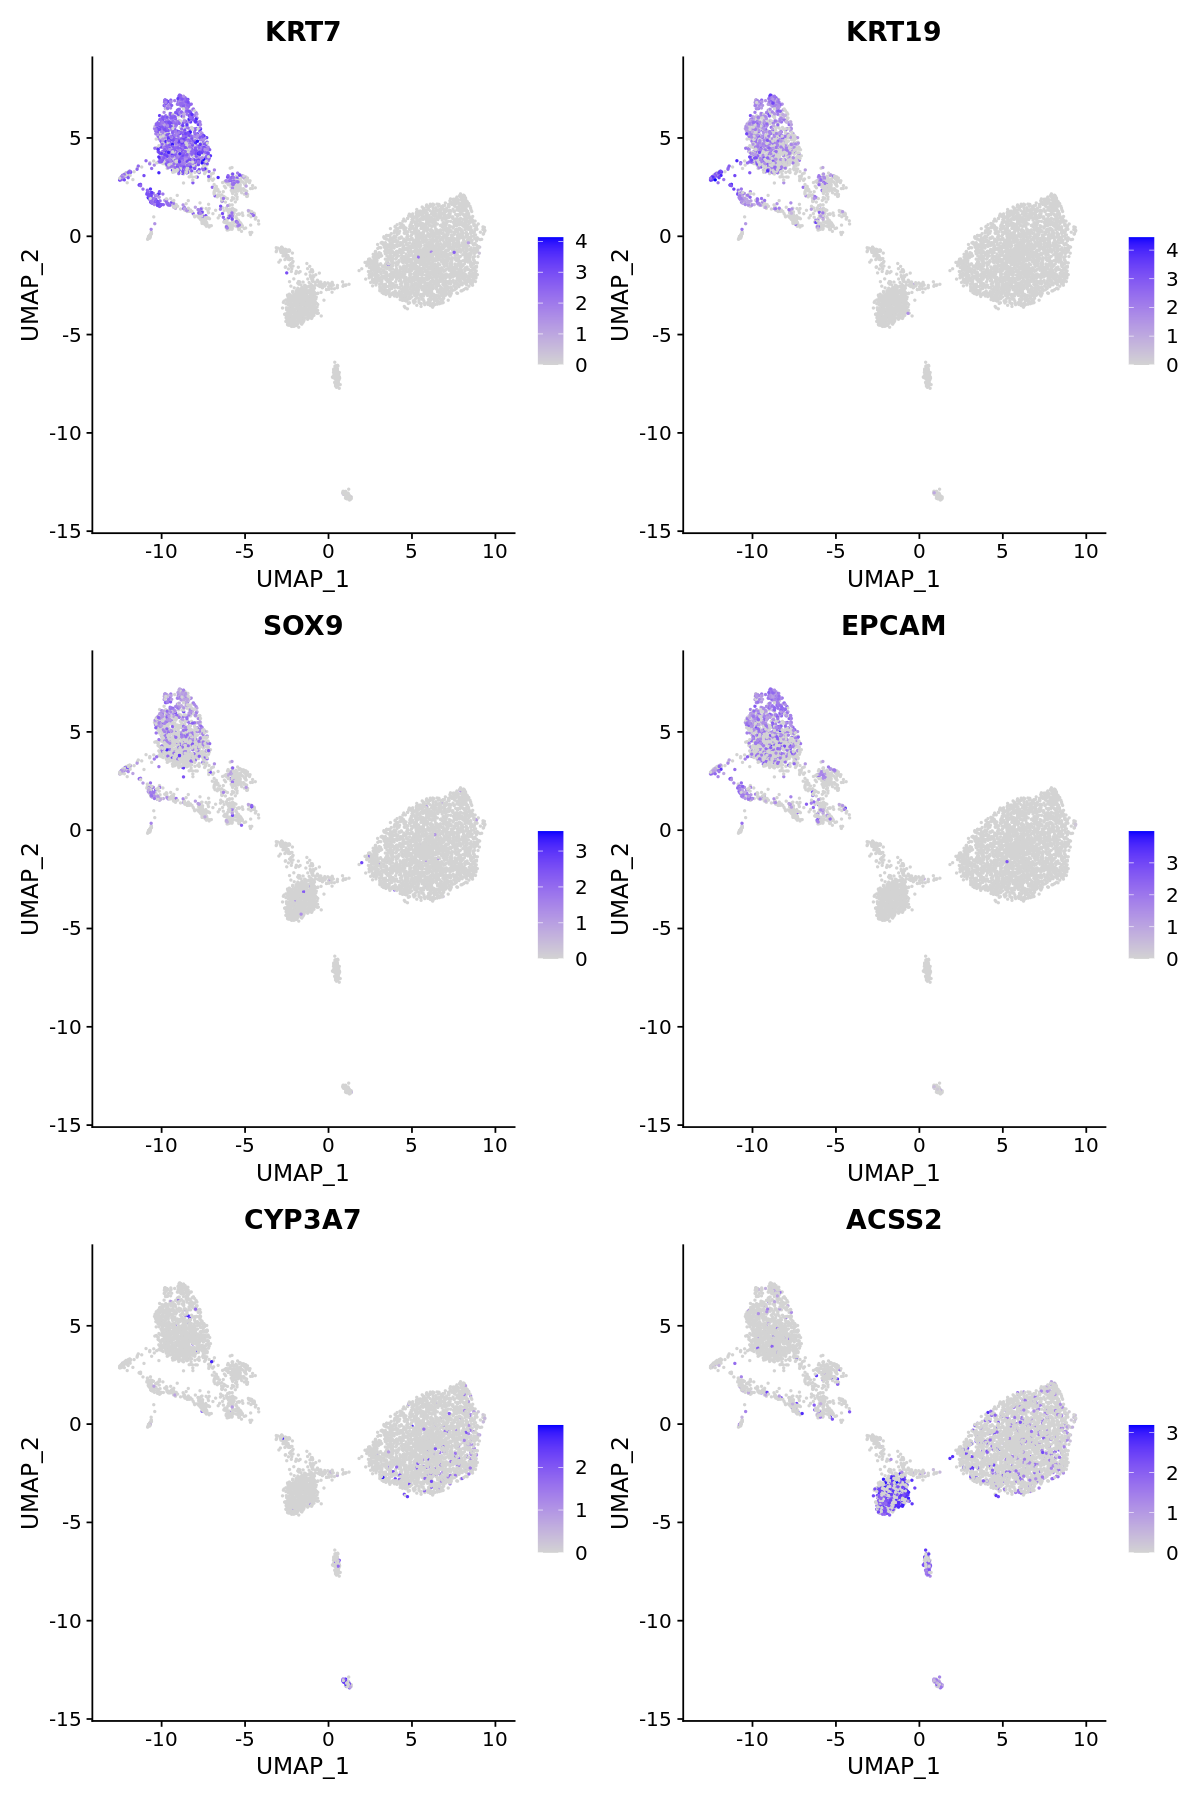

In [31]:
options(repr.plot.height=15,repr.plot.width=10)
FeaturePlot(lineage, features = c('KRT7','KRT19','SOX9','EPCAM','CYP3A7','ACSS2'), slot = 'data')

In [33]:
children_clusters = list()
children_clusters[['Cholangiocyte']] = c(6,0,15,12)
children_clusters[['Hepatocyte']] = c(1,4,7,5,3,14,2,13,14,11)
children_clusters[['Epithelial_Unknown']] = c(8,9,10,16)

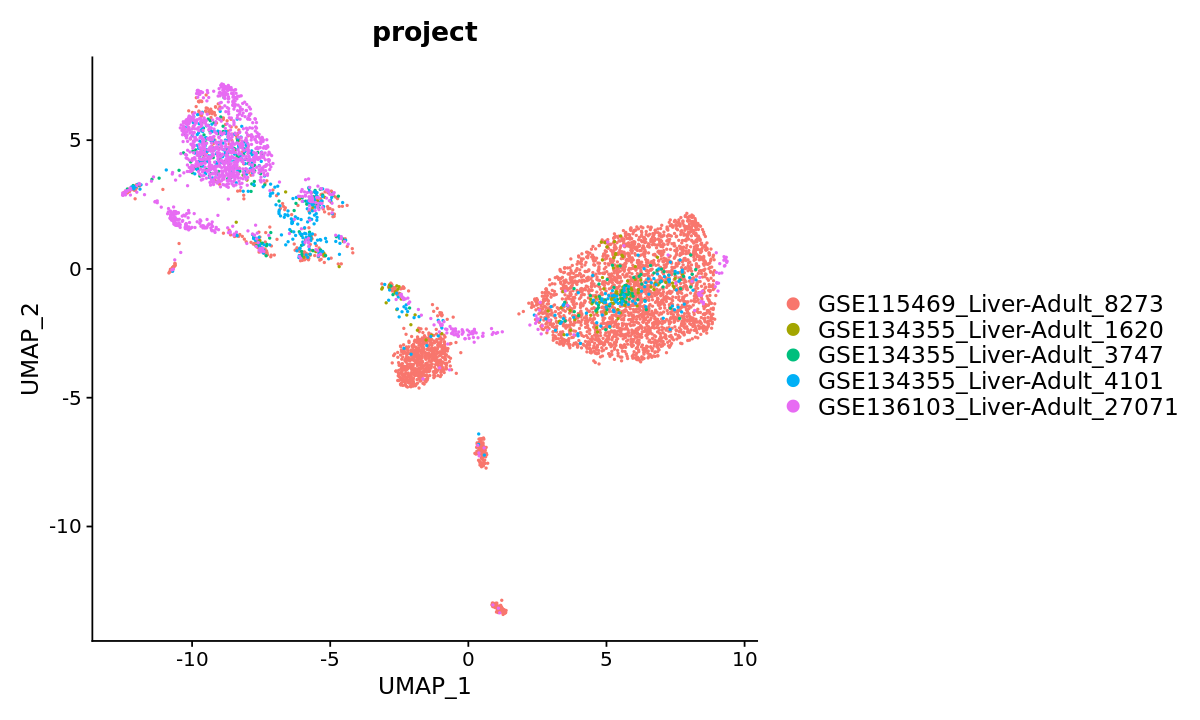

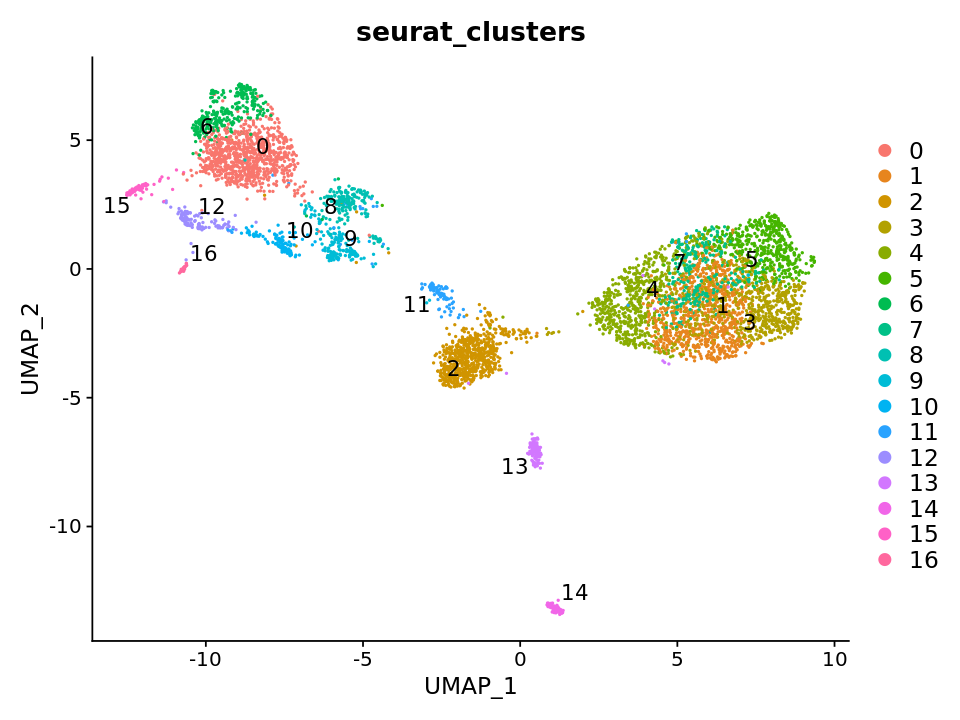

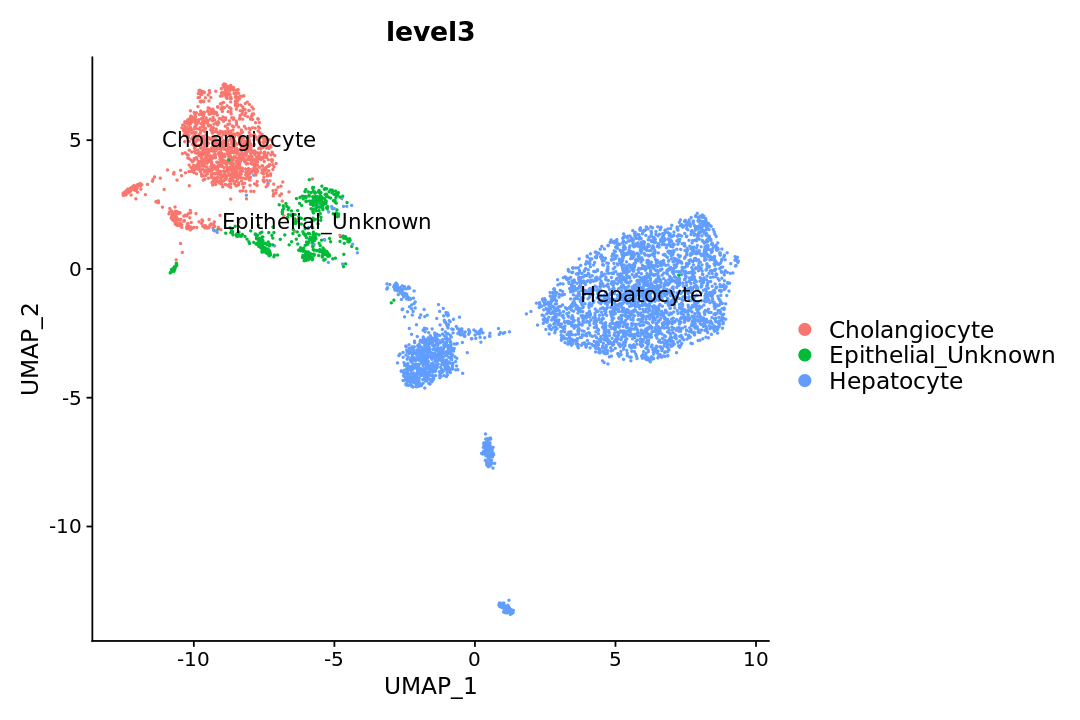

In [34]:
data_list = l3_assign(seurat_obj = lineage,children_clusters = children_clusters,Parent = 'Epithelial')

In [35]:
#DC
lineage = lineage_extract(lineage_cells = c('DC'),level = 'level2')
lineage = harmony(lineage,'project')

Warning message:
"Invalid name supplied, making object name syntactically valid. New object name is Seurat..ProjectDim.RNA.harmony; see ?make.names for more details on syntax validity"


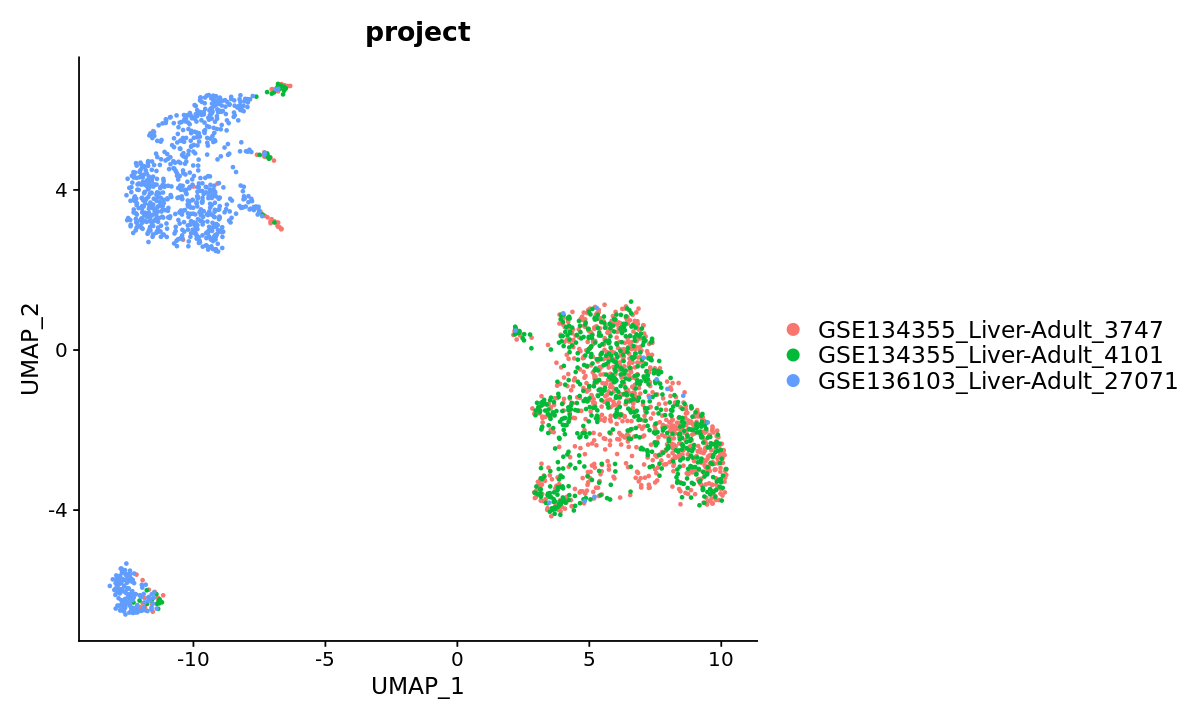

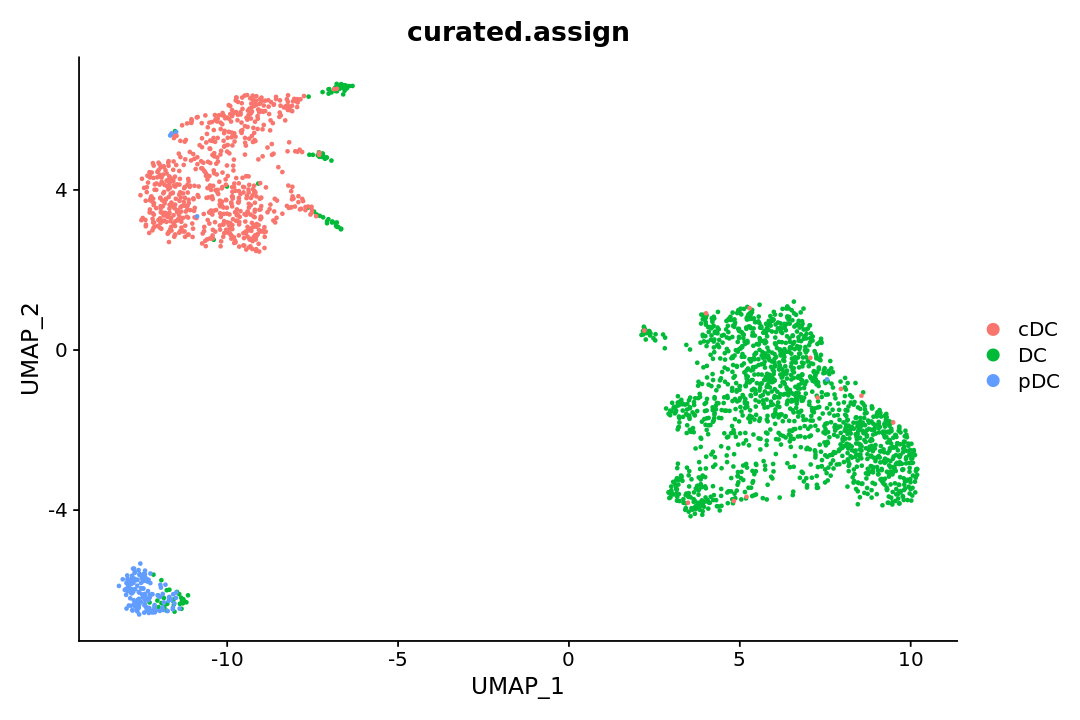

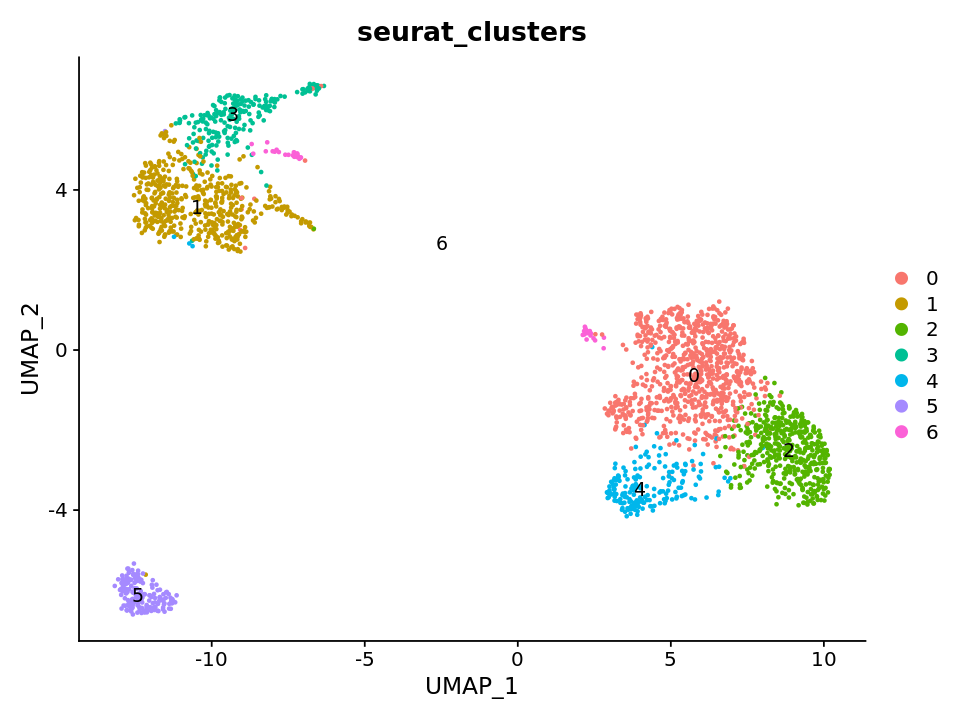

In [36]:
options(repr.plot.height=6,repr.plot.width=10)
print(DimPlot(lineage,group.by = 'project') + theme(legend.text = element_text(size = 14))) 
options(repr.plot.height=6,repr.plot.width=9)
print(DimPlot(lineage,group.by = 'curated.assign'))
options(repr.plot.height=6,repr.plot.width=8)
print(DimPlot(lineage,group.by = 'seurat_clusters',label = TRUE))

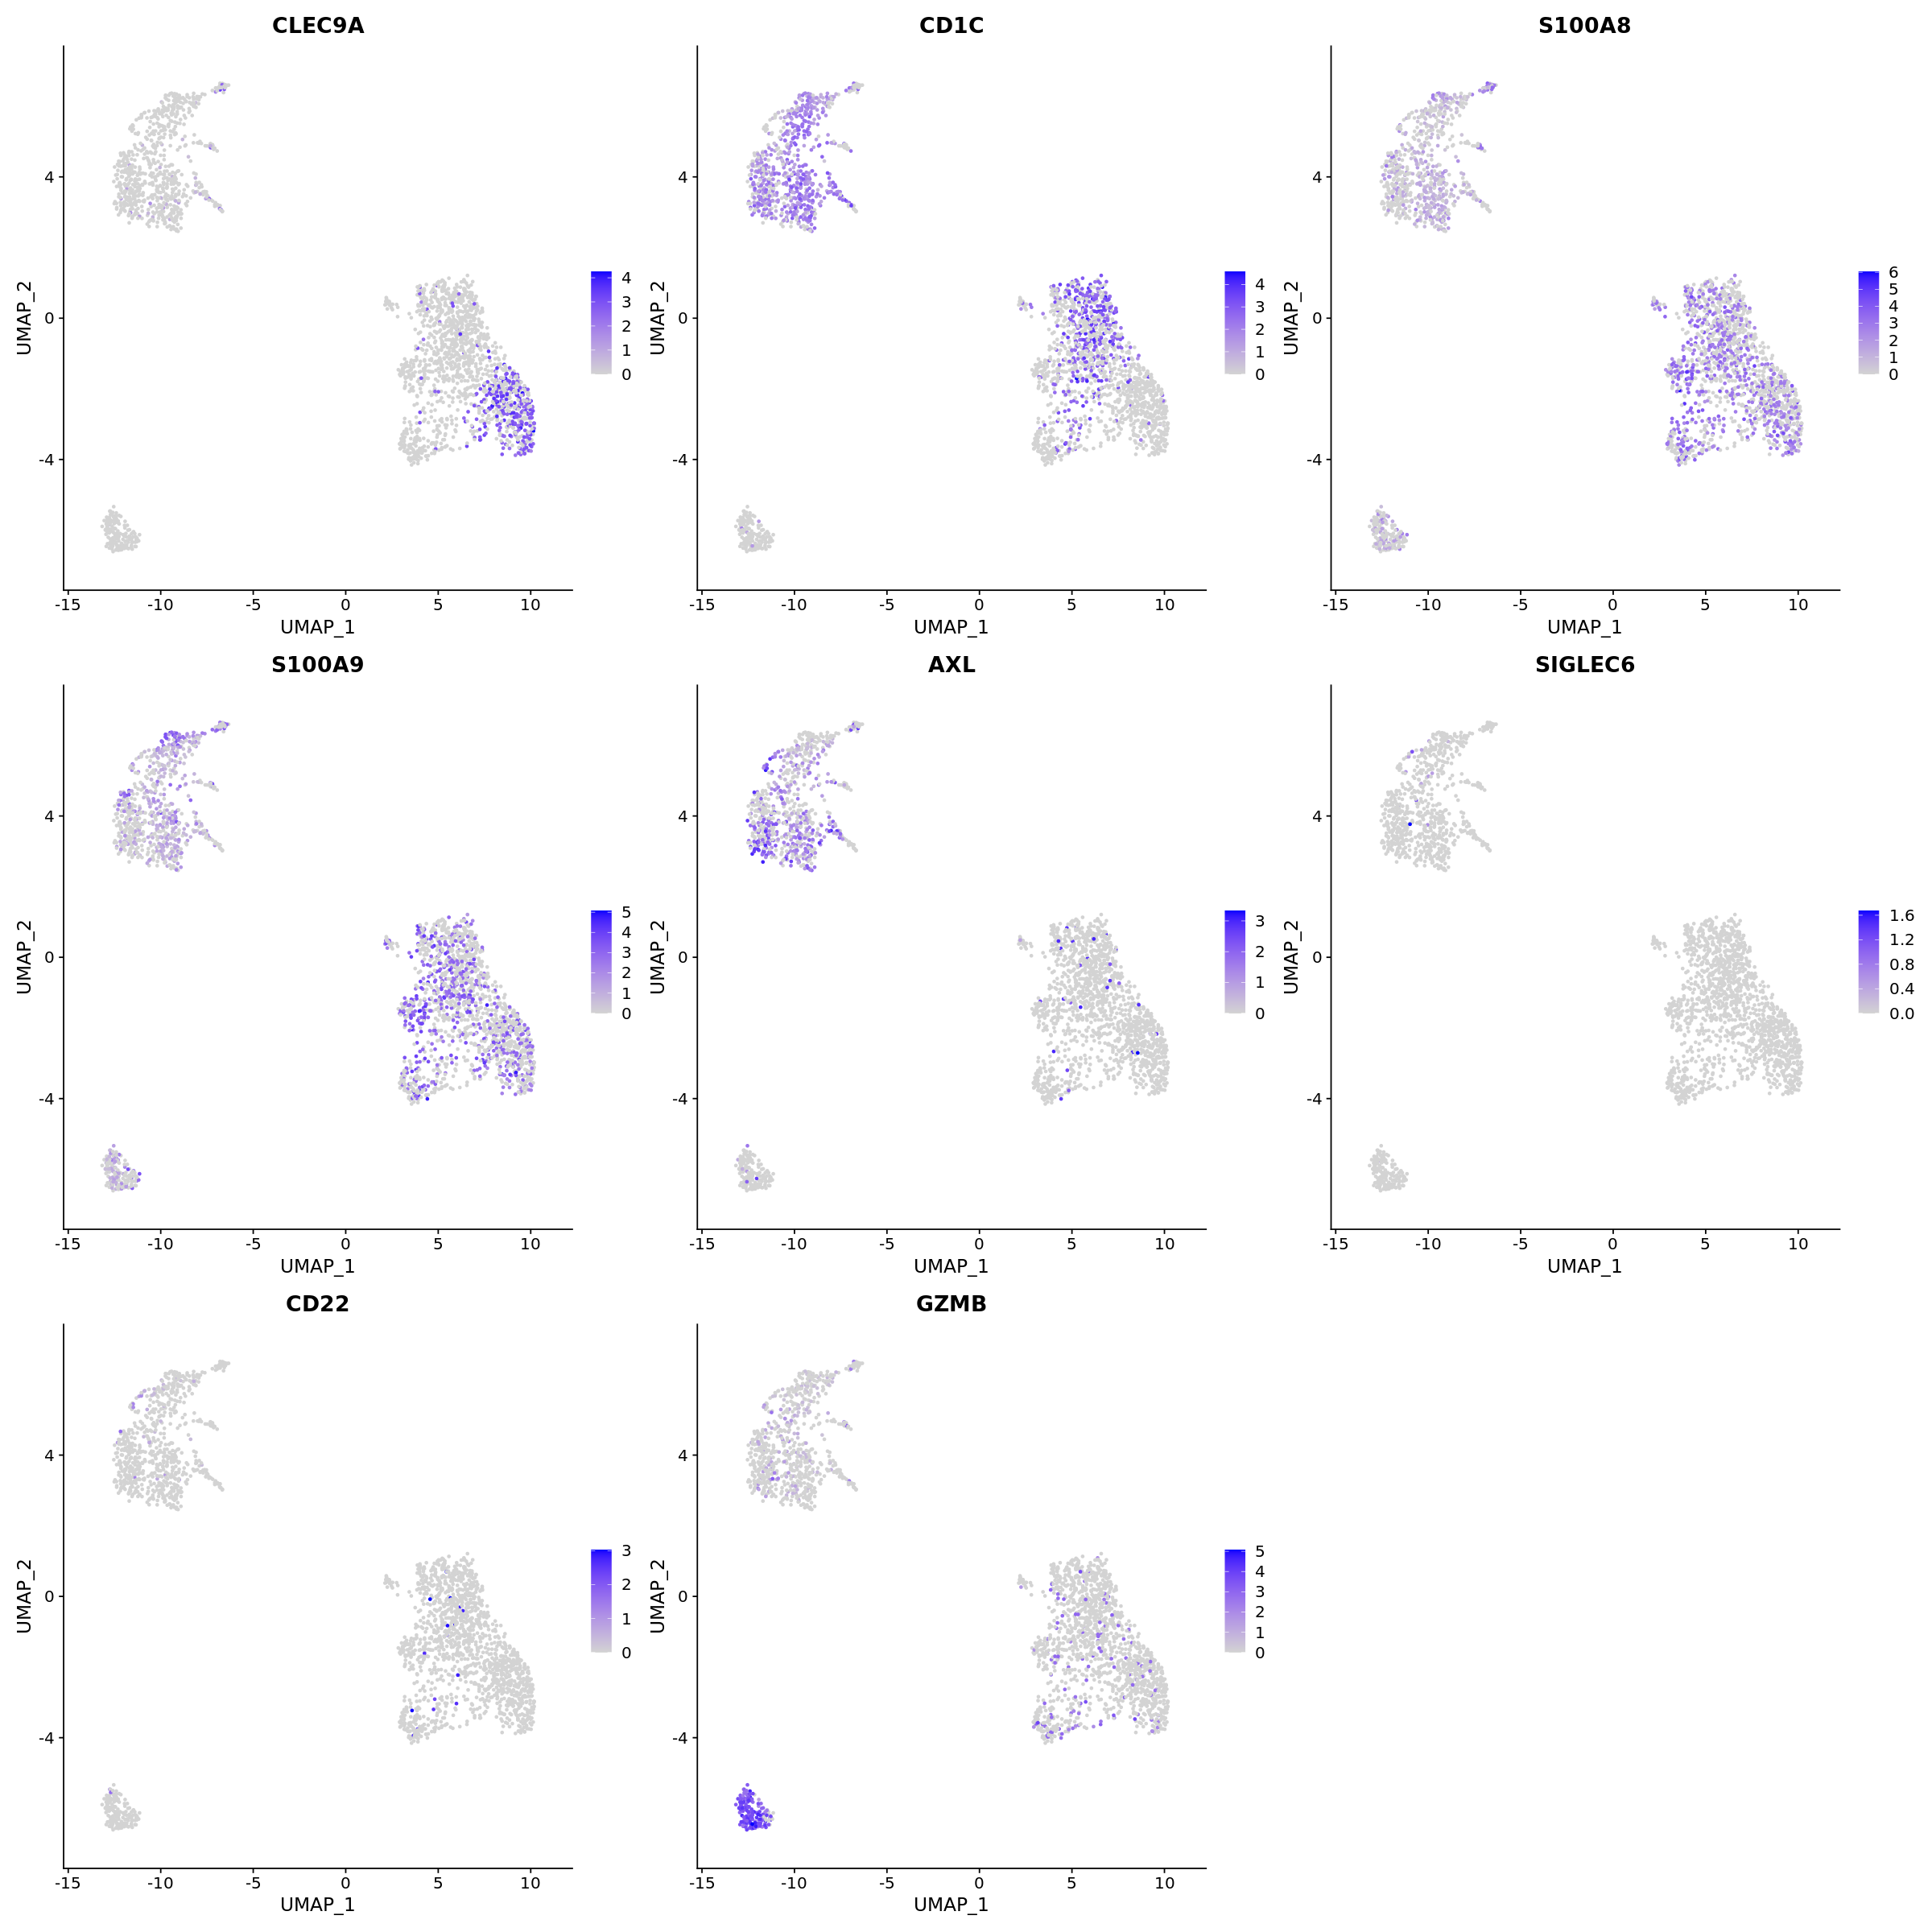

In [37]:
options(repr.plot.height=20,repr.plot.width=20)
FeaturePlot(lineage,features = c('CLEC9A','CD1C','S100A8','S100A9','AXL','SIGLEC6','CD22','GZMB'))

In [38]:
children_clusters = list()
children_clusters[['cDC1']] = c(2)
children_clusters[['cDC2']] = c(0,3,1,4,6)
children_clusters[['pDC']] = c(5)

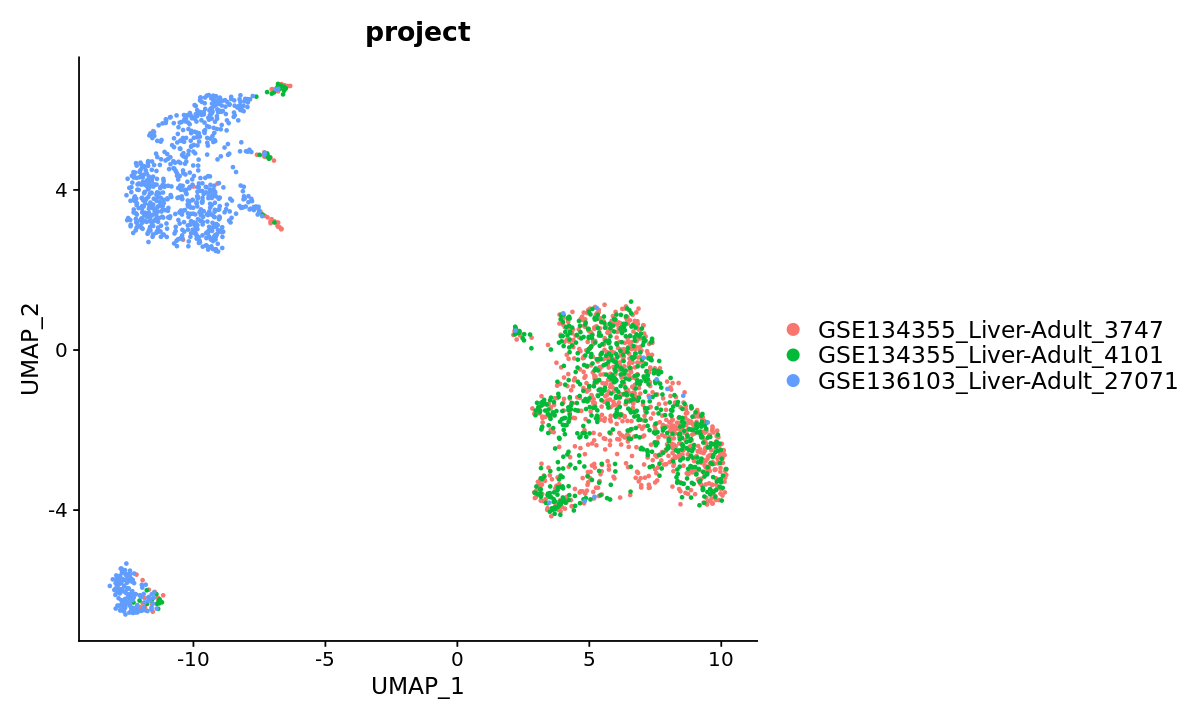

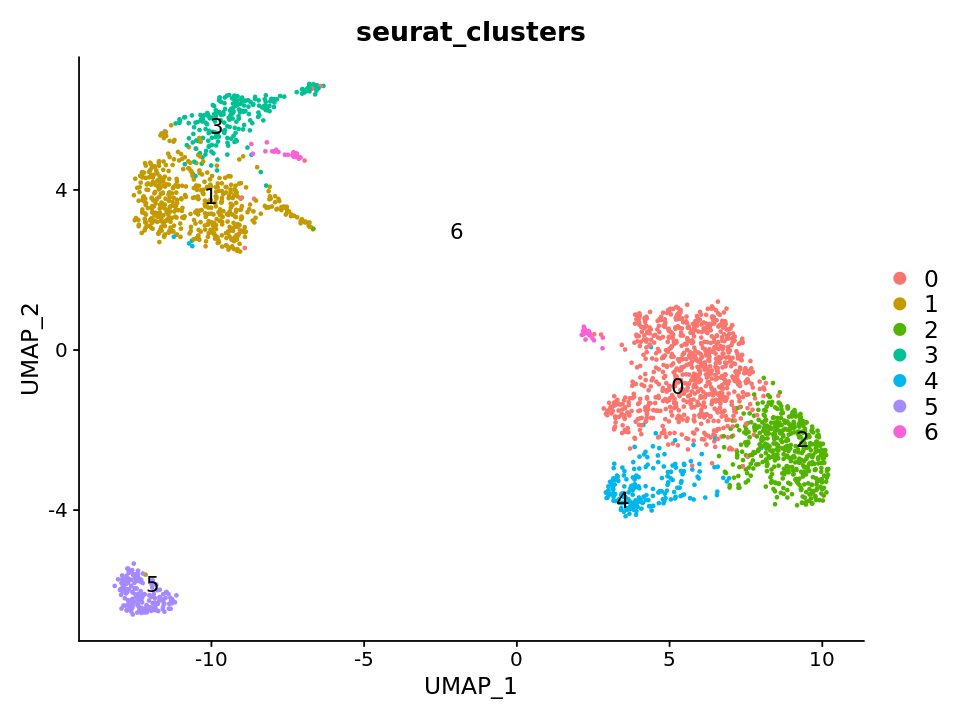

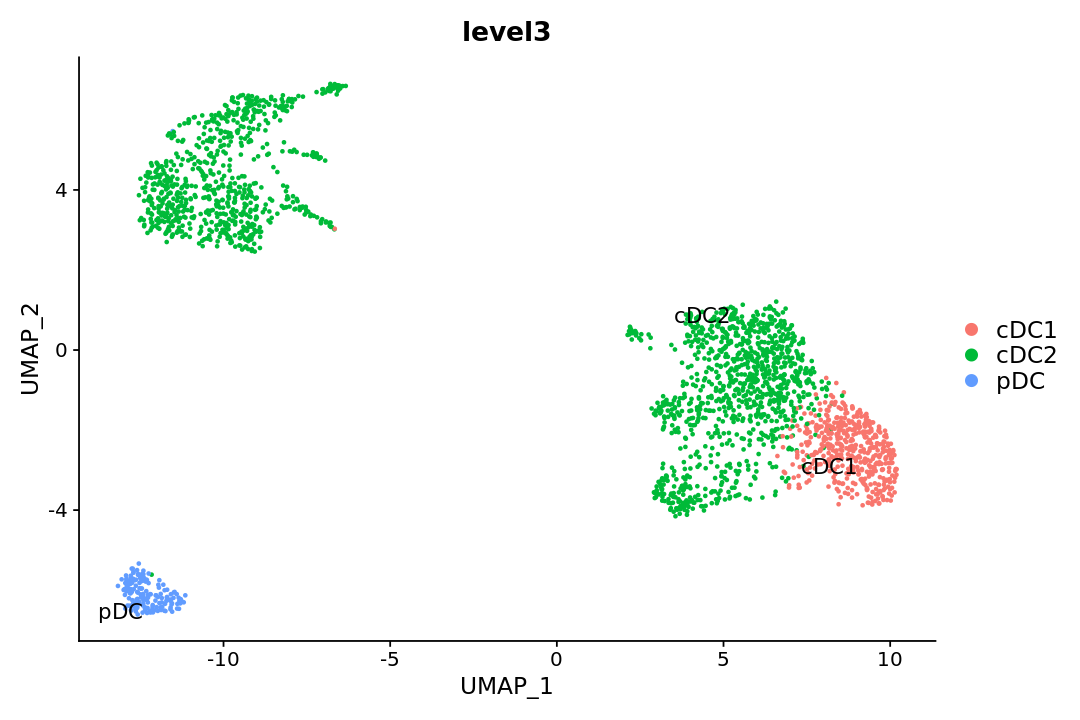

In [39]:
data_list = l3_assign(seurat_obj = lineage,children_clusters = children_clusters,Parent = 'DC')

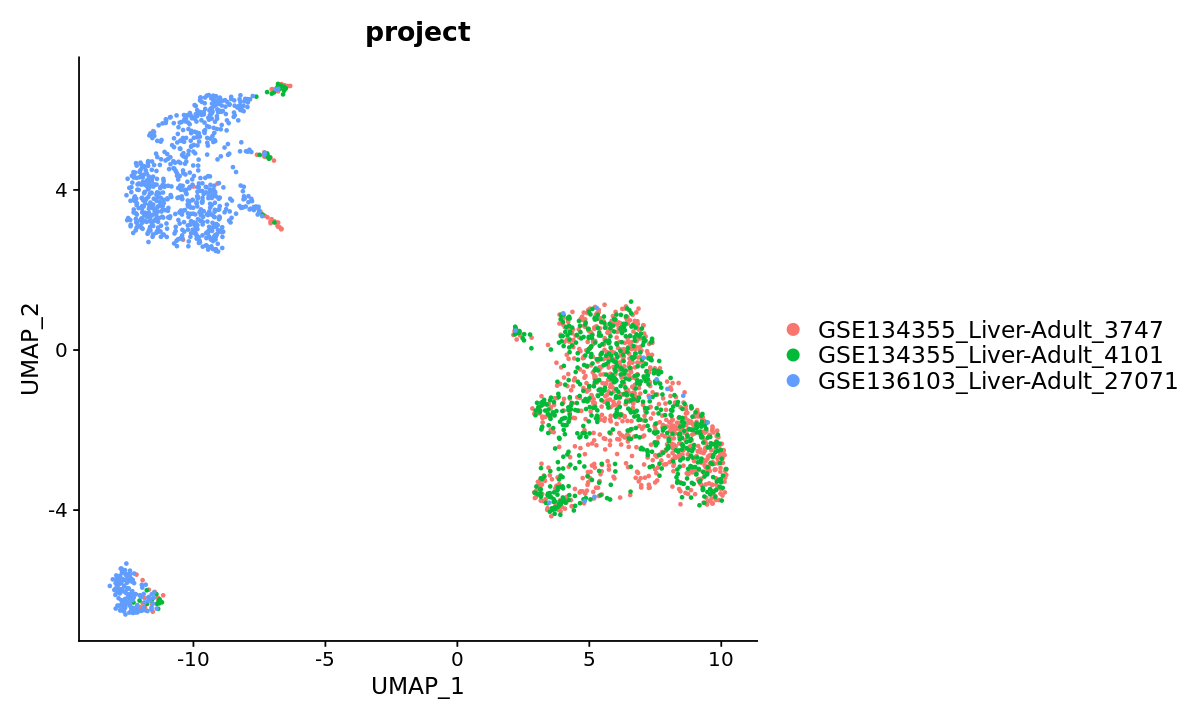

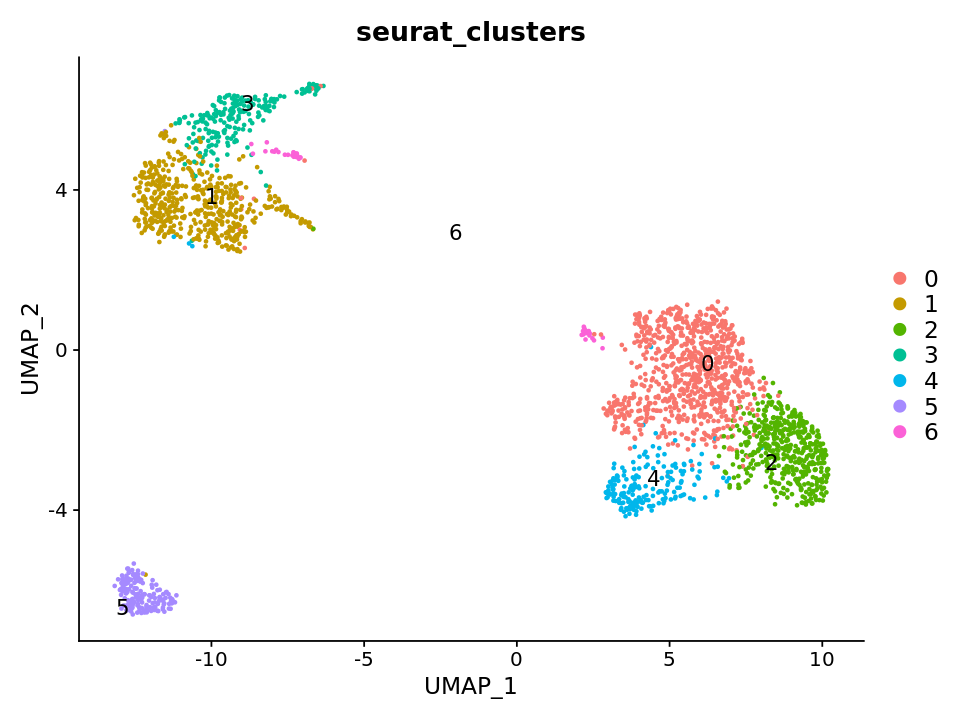

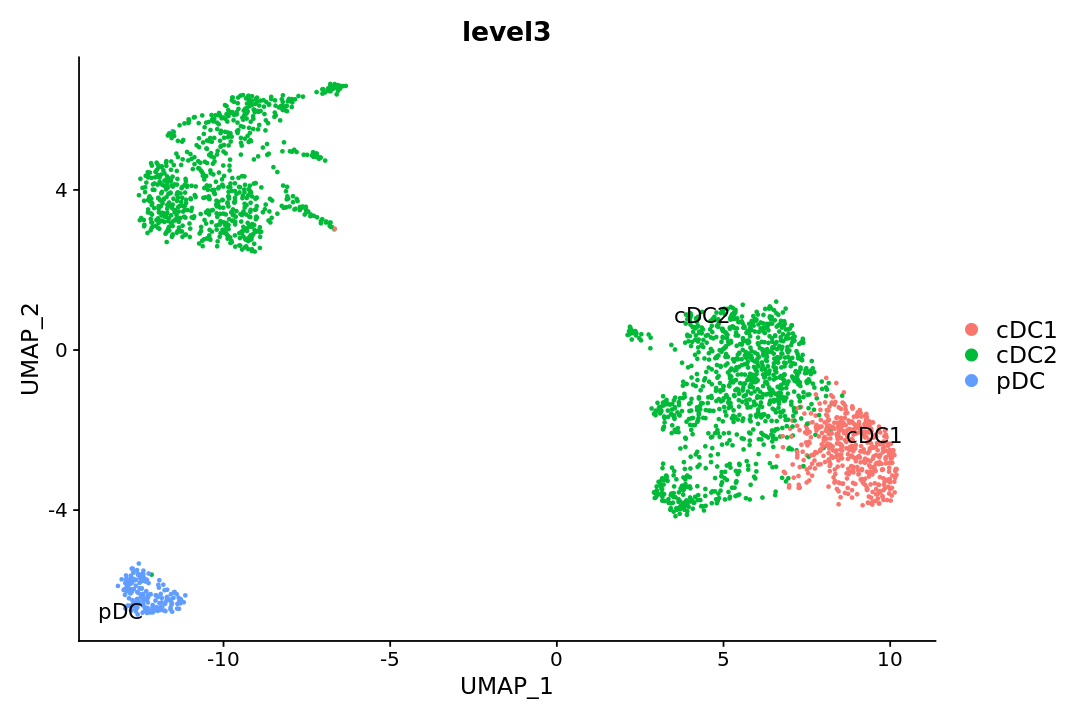

In [40]:
data_list = l3_assign(seurat_obj = lineage,children_clusters = children_clusters,Parent = 'cDC')

In [41]:
for (i in 1:length(data_list)){
    ct_number = table(data_list[[i]]$level3)
    ct = names(ct_number)
    for (j in 1:length(ct)){
        if (ct_number[j]<=10){
            if (!str_detect(ct[j],'Unknown')){
                data_list[[i]]$level3[data_list[[i]]$level3 == ct[j]] = paste0(ct[j],'_Unknown')
            }
        }
    }
}

In [42]:
celltype = c()
for (i in 1:length(data_list)){
    celltype = c(celltype,data_list[[i]]$level3)
}
celltype = celltype[!str_detect(celltype,'Unknown')]
print(as.data.frame(unique(celltype)))

      unique(celltype)
1  Central Venous LSEC
2        Cholangiocyte
3              Kupffer
4                 CD8T
5           Macrophage
6                   NK
7           Hepatocyte
8   Portal Endothelial
9      Periportal LSEC
10                   B
11              Plasma
12                CD4T
13           Erthyroid
14     Endothelial_lv3
15          Neutrophil
16                Mast
17                cDC2
18                 pDC
19                cDC1
20              Muscle
21            Monocyte
22         Mesenchymal


In [43]:
for (i in 1:length(files)){
    file = gsub('_res','',files[i])
    saveRDS(data_list[[i]],file)
}